# Traffic Sign Detection on GTSDB (DeepLearning@UniFe) 

## Info sul progetto
Questo è il notebook che contiene il codice con l'obiettivo di addestrare una rete neurale convoluzionale (CNN) per effettuare Object Detection nel caso specifico di cartelli stradali. Il dataset usato è il [GTSDB](https://benchmark.ini.rub.de/). L'architettura scelta è quella di YOLOv3 sulla quale viene effettuato fine-tuning degli ultimi layer in fase di addestramento. La rete, dopo aver identificato il cartello, lo classifica in base a 4 differenti classi: obbligo, divieto, pericolo e altro.

### Descrizione dettagliata della rete

YOLOv3 è una versione migliorata di YOLO e YOLOv2 a cura di Joseph Redmon e Ali Farhadi della University of Washington. YOLOv3 è una FCN (Fully Convolutional Network) di 106 layer pre-addestrata sul COCO dataset e implementata tramite le librerie per deep learning di Keras e OpenCV. Rispetto alle precedenti architetture (RCNNs) la rete si presenta come un blocco monolitico dove l’estrazione delle feature, box regression (localizzazione degli oggetti) e classificazione vengono unificate. A differenza quindi dei modelli precedenti con due layer di output, uno per la distribuzione di probabilità della classe e l’altro per le predizioni dei box, in YOLO il tutto è riunito in un singolo output. 

La rete prende ispirazione da ResNet e dall’architettura FPN (Feature Pyramid Network), implementando come feature extractor la sottorete pre addestrata su ImageNet Darknet-53 (52 layer convoluzionali), contiene skip connection e tre output di predizione, ciascuno dei quali processa l’immagine a scale differenti, tramite dei downsampling rispettivamente di 32, 16 e 8 delle dimensioni delle immagini di input. La detection fatta su scale differenti risolve in parte alcune criticità nel riconoscimento di oggetti di piccole dimensioni e ci è sembrata ideale come applicazione al nostro problema riguardante nel particolare i cartelli stradali.<br>

Per rendere possibile l'addestramento in fase di addestramento in tempi ragionevoli con gli strumenti a nostra disposizione viene utilizzato la tecnica del "transfer learning" che consiste nell'addestramento di una rete pre-addestrata su un dataset di immagini di grandi dimensioni, in questo caso COCO, e poi di una nuova rete che si basa sulla rete addestrata e che differesce da quest'ultima negli ultimi layer. Nello specifico viene mantenuta la backbone (usata come feauture extractor) Darknet-53 e vengono riaddestrati gli ultimi layer. Non sarebbe possibile usare YOLO "originale" perché COCO non contiene immagini di cartelli stradali.

Paper di riferimento sulla rete [YOLOv3: An Incremental Improvement](https://pjreddie.com/media/files/papers/YOLOv3.pdf).

### Installazione librerie e prerequisiti
Per eseguire il codice di seguito è necessario installare le seguenti librerie: 
tensorflow, numpy, pandas, matplotlib, seaborn e opencv-python (usando anche il comando pip install). Non è escluso che altre possano essere necessarie.

È necessario che questo file sia in una directory che contiente le directory TrainIJCNN2013 e TestIJCNN2013 (che contengono i file .ppm con i dati di training e test). Sono scaricabili dal sito [GTSDB](https://benchmark.ini.rub.de/). Inoltre è necessario che diverse directory esistano e devono essere quindi create manualmente quando scritto.

È inoltre necessario che alcune directory (anche vuote) esistano nella directory corrente. Queste sono tutte quelle che si vedranno nelle prime righe di ogni cella, in cui vengono configurati i path.  

La parte di creazione del modello è indipendente dalla precedente e usa solamente i file tfrecord creati dalla prima parte oltre ai file delle immagini convertite in JPG. È possibile quindi testare l'addestramento con diversi Hyperparametri senza dover ri-creare i file tfrecord e ripetere le fasi iniziali.

Le informazioni sul codice se brevi sono scritte come commenti all'inizio di ogni cella oppure se più consistenti come cella Markdown precedente al codice.  

Per semplificare l'utilizzo del codice è stato usato il modulo di logging di python. Questo permette di stampare in una finestra di console i messaggi di log. Per modificare il livello di "verbosità" usare logging.setVerbosity("info") o logging.setVerbosity("warning") dato che sono gli unici utilizzati. Gli errori critici stampano sul stdout usando le normali print. Questo per mantenere un output più pulito e facile da leggere. In caso di errori meglio passare al livello info per avere più dettagli per debuggare.  
### Risoluzione problemi frequenti e consigli vari
Se VSCODE non riesce a collegarsi al kernel riavviare il kernel  

Meglio NON USARE "ESEGUI TUTTE" (ci mette troppo tempo)  

Errore directory non trovata -> crearla a mano (oppure rieseguire la cella che potrebbe averla creata in automatico)





## Data loading and analysis
A partire dai file .ppm presenti nel dataset i dati vengono analizzati e convertiti in un formato che può essere usato dalla rete neurale. Inoltre viene creato un Pandas Dataframe che contiene tutte le informazioni sui dati (nome immagine, bounding box, classe).  

Nella cella seguente viene generato e popolato il DF Pandas contenente i dati di training.

In [1]:
#Import comuni a tutte le celle (anche se alcuni saranno ripetuti successivamente)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
from absl import logging

#setting logging verbosity
logging.set_verbosity("warn")

#in che directory siamo?
logging.info("Directory attuale: ", os.getcwd() )


#Condigurazione path: cartella con immagini di training (ancora .ppm)
train_path = os.path.join(os.getcwd(), 'TrainIJCNN2013\\')

#Verifico esistenessa cartella train
if not os.path.exists(train_path):
    logging.warn("Cartella Train non esistente: ", train_path)
    logging.warn("Scaricare il dataset (train) ed estrarre lo zip nella directory:",train_path)
    exit()
else:
    logging.info("Cartella Train esistente, deve contenere i file .ppm di training: ", train_path)


#gt.txt file with truth value (label)
#600 immagini di training
data = pd.read_csv(train_path+"/gt.txt",sep=';',names=['path','left','top','right','bottom','id'])

#controllo numero righe
logging.info(str(data.count()[0])+" righe DF traing")

if data.count()[0] != 852:
    logging.warn("Numero righe non corretto, verificare correttezza (e presenza) del file gt.txt")
else:
    logging.info("Numero righe corretto")

data.head()



,path,left,top,right,bottom,id
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


Analisi delle immagini. Test per verificare che le immagini siano correttamente caricate e visualizzabili e analisi del numero di rappresentazione per ogni cartello (sia singolarmente che per tipologia)

C:\Users\Michela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


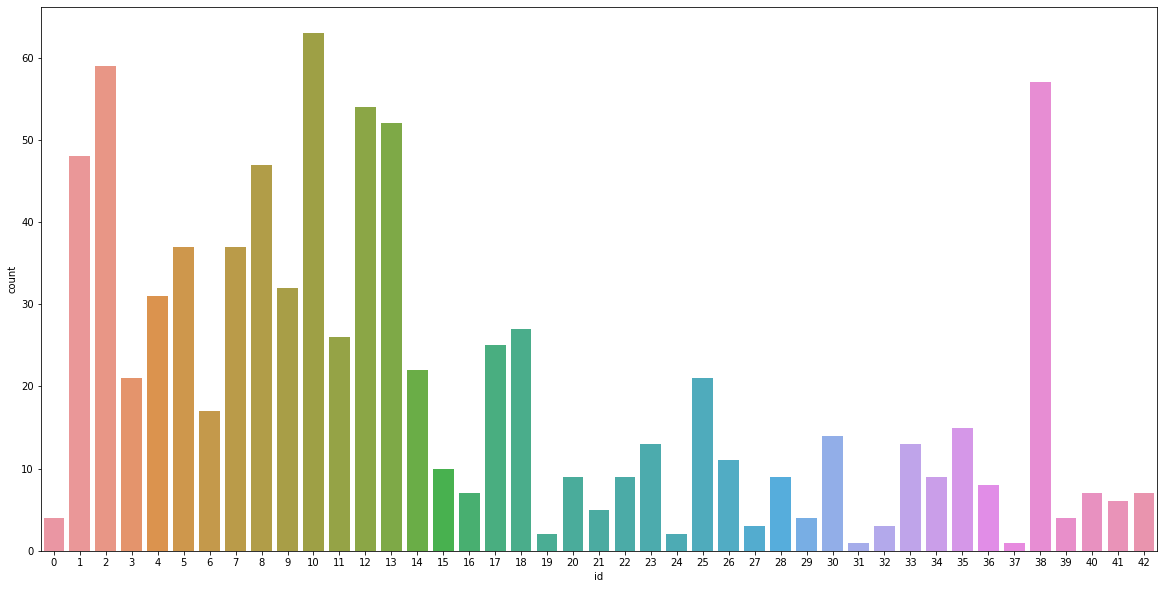

In [2]:
import seaborn as sns

plt.figure(figsize=(20,10))
#plotting count plot with seaborn
sns.countplot(data['id']);

#notiamo una grande differenza di rappresentazione

### Divisione in categorie
I cartelli vengono in divisi in 4 categorie diverse (vedi sotto) in modo da poter fare un riconoscimento più preciso data la disponibilità di sole 600 immagini per 42 cartelli diversi.

In [3]:
#Divisione in categorie (usando le informazioni ufficiali del dataset) 
prohibitory = [0,1,2,3,4,5,7,8,9,10,15,16]
danger = [11,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
mandatory = [33,34,35,36,37,38,39,40]
other = [6,12,13,14,17,32,41,42]

#id è la classe a cui appartiene il cartello
data ['Object Name'] = data['id']

#aggiungo la colonna "object_name" che rappresenta la categoria
#assigning new labels, 1 implies prohibitory,2 implies danger,3 implies mandatory and 4 implies other.
for i in range(len(data['id'])):
  if(data['id'][i] in prohibitory):
    data['id'].loc[i]=0
    data['Object Name'].loc[i]='prohibitory'
  elif(data['id'][i] in danger):
    data['id'].loc[i]=1
    data['Object Name'].loc[i]='danger'
  elif(data['id'][i] in mandatory):
    data['id'].loc[i]=2
    data['Object Name'].loc[i]='mandatory'
  elif(data['id'][i] in other):
    data['id'].loc[i]=3
    data['Object Name'].loc[i]='other'
  else:
    data['id'].loc[i]=-1


#Ora i cartelli sono divisi in 4 classi (non più 43)
print(data)

C:\Users\Michela\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


          path  left  top  right  bottom  id  Object Name
0    00000.ppm   774  411    815     446   1       danger
1    00001.ppm   983  388   1024     432   2    mandatory
2    00001.ppm   386  494    442     552   2    mandatory
3    00001.ppm   973  335   1031     390   3        other
4    00002.ppm   892  476   1006     592   2    mandatory
..         ...   ...  ...    ...     ...  ..          ...
847  00570.ppm   881  416    914     449   0  prohibitory
848  00571.ppm  1287  361   1308     384   3        other
849  00575.ppm   403  474    435     506   2    mandatory
850  00593.ppm   584  510    608     534   2    mandatory
851  00599.ppm   700  454    722     476   0  prohibitory

[852 rows x 7 columns]


Analisi delle frequenze dei segnali divisi in 4 categorie. Dal grafico notiamo ancora un certo sbilanciamento verso la classe 0 (prohibitory) ma ogni classe è rappresentata da almeno 100 esempi. Successivamente si analizzano le frequenze nelle dimensioni delle BB.

C:\Users\Michela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


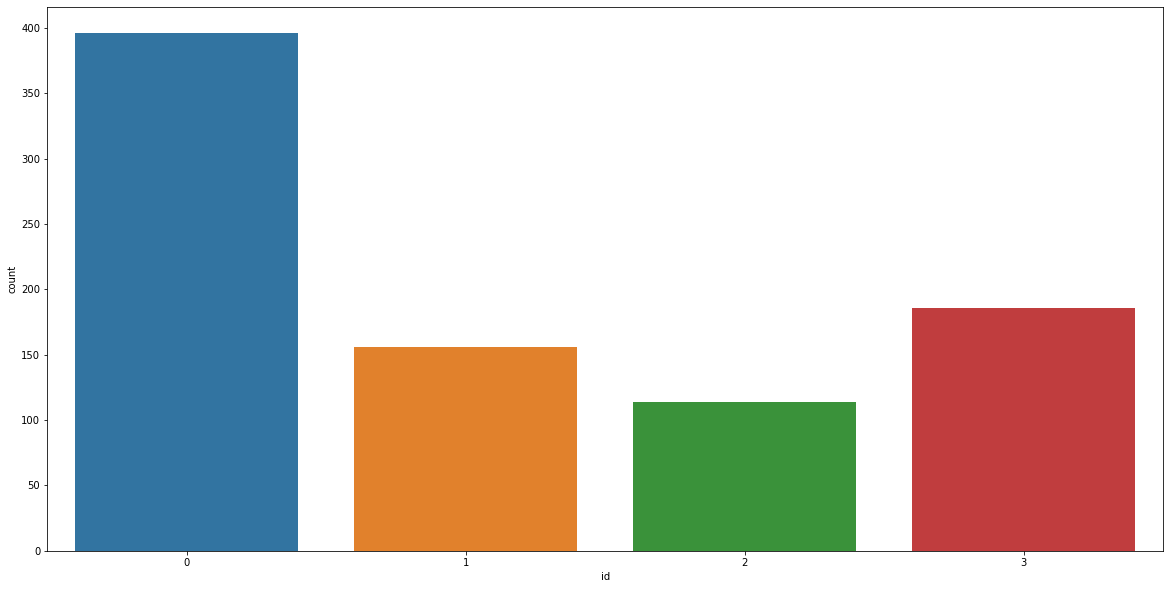

In [4]:
import seaborn as sns
plt.figure(figsize=(20,10))
#plotting count plot with seaborn
sns.countplot(data['id']);

#conteggio classi

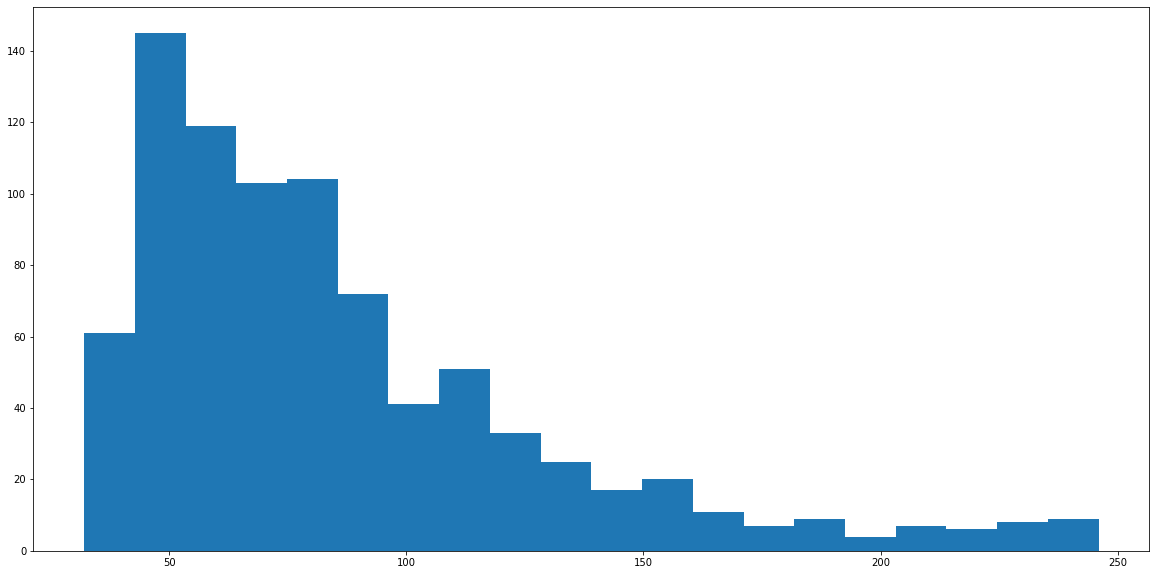

In [5]:
#dimensione bounding box
box_size=[]
for i in range(len(data)):
  bounding = data['bottom'][i]-data['top'][i]+data['right'][i]-data['left'][i]
  box_size.append(bounding)
plt.figure(figsize=(20,10))
plt.hist(box_size, bins=20);

## Data preprocessing
CSV (gt.txt) -> XML -> tfrecord

### Conversione in JPG
In questa sezione vengono convertite le immagini in JPG, le etichette in XML (come passaggio intermedio) ed infine in tfrecord. I file tfrecord sono usati poi in fase di addestramento del modello (senza le operazioni viste sopra).



In [6]:
#conversione in JPG
from absl import logging

if not (os.path.exists(os.getcwd()+"\\content\\images")):
  logging.warning("Cartella content\content non esistente. Provo a crearla!")
  os.mkdir(os.getcwd()+"\\content\\images")
  sys.exit()
#per un output pulito non scommentare le print

final_df=pd.DataFrame(columns=data.columns)

#mi muovo in tutte le cartelle
for current_dir, dirs, files in os.walk(train_path):
     for f in files:
        #print(train_path+ f)
        #Check if a file end with .ppm format or not
        if f.endswith('.ppm'):
            #rimuovo le immagini senza nessun cartello
            image_name=f[:-4]
            img=cv2.imread(train_path + f)
            #print(img)
            single_yolo_dat = data.loc[data['path'] == f].copy()

            #è necessario anche modificare il nome del file (l'estensione)
            single_yolo_dat["path"] = single_yolo_dat["path"].apply(lambda x: x[:-4]+".jpg")

            # and, in this way, initial dataFrame will not be changed
            # Checking if there is no any annotations for current image
            if single_yolo_dat.isnull().values.all():
                # Removing this image from train data
                # print(f)
                os.remove(train_path + '\\' + f)
                
            #Now save the resulted_frame to a folder inside train_path
            else:
              #deprecato:
              final_df=final_df.append(single_yolo_dat)

              #funziona male:
              #final_df = pd.concat([final_df, single_yolo_dat], ignore_index=True)
              
              #Now writng and saving the image from ppm format to jpg format using OpenCV
              save_path = os.getcwd() + '\\content\\images' + '\\' + image_name + '.jpg'
              cv2.imwrite(save_path, img)
#tilde = not
#elimino se ci sono delle righe duplicate nel DF
final_df = final_df[~final_df.index.duplicated(keep='first')]
final_df.sort_index(inplace=True)

final_df.head(5)

,path,left,top,right,bottom,id,Object Name
0,00000.jpg,774,411,815,446,1,danger
1,00001.jpg,983,388,1024,432,2,mandatory
2,00001.jpg,386,494,442,552,2,mandatory
3,00001.jpg,973,335,1031,390,3,other
4,00002.jpg,892,476,1006,592,2,mandatory


### Creazione file XML

A partire dai file con le immagini e dal file gt.txt vengono creati i file XML usati successicamente per produrre i .tfrecord.

In [7]:
#creazione file con annotazioni XML
#dataframe to xml file
#Fonte del codice:
#https://gist.github.com/goodhamgupta/7ca514458d24af980669b8b1c8bcdafd



import os
import xml.etree.cElementTree as ET
from PIL import Image
import sys

from absl import logging

#per debugging meglio info
logging.set_verbosity("warn")

#cartella con le immagini
ANNOTATIONS_DIR_PREFIX = ".\\content\\images"

#cartella con le destinazioni
DESTINATION_DIR = ".\\content\\XML"

if not (os.path.exists(os.getcwd()+"\\content\\XML")):
  logging.warning("Cartella content\XML non esistente. Provo a crearla! Rieseguire la cella.")  
  os.mkdir(os.getcwd()+"\\content\\XML")
  sys.exit()

if not (os.path.exists(os.getcwd()+"\\content\\images")):
  logging.warning("Cartella content\images non esistente. Dovrebbe contenere le immagini di training. Termino!")
  sys.exit()




#Classi da identificare
CLASS_MAPPING = {
    '0': 'prohibitory',
    '1': 'danger',
    '2': 'mandatory',
    '3': 'other'
}

def create_root(filename, width, height):
    root = ET.Element("annotation")
    ET.SubElement(root, "folder").text = "images"
    ET.SubElement(root, "filename").text = (filename)
    ET.SubElement(root, "path").text = "images/{}".format(filename)
    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "Unknown"
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    ET.SubElement(root, "segmented").text = "0"
    return root

def create_object_annotation(root, voc):
    for ind,voc_label in voc.iterrows():
        obj = ET.SubElement(root, "object")
        logging.info(voc_label["id"])
        ET.SubElement(obj, "name").text=str(CLASS_MAPPING.get(str(voc_label["id"])))
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = str(0)
        ET.SubElement(obj, "difficult").text = str(0)
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(voc_label["left"])
        ET.SubElement(bbox, "ymin").text = str(voc_label["top"])
        ET.SubElement(bbox, "xmax").text = str(voc_label["right"])
        ET.SubElement(bbox, "ymax").text = str(voc_label["bottom"])
    if(len(voc)==0):
        print('no')
        #print(voc)
    return root


def create_file(filename, width, height, voc):
    root = create_root(filename, width, height)
    root = create_object_annotation(root, voc)
    tree = ET.ElementTree(root)
    tree.write("{}/{}.xml".format(DESTINATION_DIR, filename[:-4]))


def read_file(filename):
    img = cv2.imread("{}/{}".format("images/", filename))
    w,h=img.shape[:2]
    voc = final_df.loc[final_df["path"] == filename].copy()
    voc["name"] = CLASS_MAPPING.get(str((voc["id"])))
    create_file(filename, w, h, voc)


def start():
    if not os.path.exists(DESTINATION_DIR):
        os.makedirs(DESTINATION_DIR)
    for filename in os.listdir(ANNOTATIONS_DIR_PREFIX):
          if filename.endswith(".jpg"):
            logging.info(filename)
            read_file(filename)
            
      


if __name__ == "__main__":
    start()

## Model creation
In questa parte viene implementato il modello, usando le API di Tensorflow (con interfaccia Keras), YOLOv3 e le funzioni di addestramento.

Questo codice deve essere eseguito sia per la fase di training che per quella di test, altrimenti non ci sarebbe nessun modello da testare.

### Tfrecord utility functions
Servono per interagire con i file tfrecord.

In [3]:
import tensorflow as tf
from absl.flags import FLAGS
yolo_max_boxes =  100
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    # tf.print(indexes.stack())
    # tf.print(updates.stack())

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32
    
    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)


def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train


# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md#conversion-script-outline-conversion-script-outline
# Commented out fields are not required in our project
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}


def parse_tfrecord(tfrecord, class_table, size):
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)

    paddings = [[0, yolo_max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train


def load_tfrecord_dataset(file_pattern, class_file, size=416):
    LINE_NUMBER = -1  # TODO: use tf.lookup.TextFileIndex.LINE_NUMBER
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter="\n"), -1)

    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    return dataset.map(lambda x: parse_tfrecord(x, class_table, size))


def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])][0], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
        
    return img


def load_fake_dataset():
    x_train = tf.image.decode_jpeg(
        open('./data/girl.png', 'rb').read(), channels=3)
    x_train = tf.expand_dims(x_train, axis=0)

    labels = [
        [0.18494931, 0.03049111, 0.9435849,  0.96302897, 0],
        [0.01586703, 0.35938117, 0.17582396, 0.6069674, 56],
        [0.09158827, 0.48252046, 0.26967454, 0.6403017, 67]
    ] + [[0, 0, 0, 0, 0]] * 5
    y_train = tf.convert_to_tensor(labels, tf.float32)
    y_train = tf.expand_dims(y_train, axis=0)

    return tf.data.Dataset.from_tensor_slices((x_train, y_train))

### Creazione file tfrecord
Questa parte dovrebbe appartenere alla parte di preprocessing ma per comodità (dato che contiene le funzioni di lettura tfrecord) è stata messsa qui. In ogni caso per completare la parte di preprocessing è necessario eseguirla.

Prima di tutto si creato 2 file .txt contenenti i nomi delle immagini che apparterranno al dataste di train o a quello di validation. L'assegnamento è casuale a partire dal datafram final_df e con percentuale 80 - 20.

In [9]:
#Divisione in training e validation

#Rimescolamento casuale del dataframe
shuffled = final_df.sample( len(final_df ))

#Calcolo il numero degli esempi nel train-dataset (il resto nel velidation) 
n_esempi = 80* len(final_df) // 100




#training
a = shuffled[:n_esempi]['path']

MyFile=open('.\content\\imageset\\train.txt','w')
for element in a:
     MyFile.write(element[:-4]+'\n')
MyFile.close()

#validation
a = shuffled[n_esempi:]['path']
MyFile=open('.\content\\imageset\\valid.txt','w')
for element in a:
     MyFile.write(element[:-4]+'\n')
MyFile.close()



 Necessario copiare la cartella images con le jpg nelle cartella \content se non è già presente.

In [10]:
#Creazione file TFRECORD training

import time
import os
import hashlib
from absl import app, flags, logging
import tensorflow as tf
import lxml.etree
import tqdm
data_dir = '.\content\\'
split = 'train'
output_file =  '.\content\\train.tfrecord'
classes = '.\content\\obj.names'

#Controllo direcotory
if not (os.path.exists(os.getcwd()+"\\content\\images")):
  logging.warning("Cartella content\images non esistente. Dovrebbe contenere le immagini JPG. Termino!")
  sys.exit()

if not (os.path.exists(os.getcwd()+"\\content\\XML")):
  logging.warning("Cartella content\XML non esistente. Dovrebbe contenere le immagini JPG. Termino!")
  sys.exit()

def build_example(annotation, class_map):
    img_path = os.path.join(
        data_dir, 'images', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()
    width = int(annotation['size']['height'])
    height = int(annotation['size']['width'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}


class_map = {name: idx for idx, name in enumerate(
    open(classes).read().splitlines())}
logging.info("Class mapping loaded: %s", class_map)

writer = tf.io.TFRecordWriter(output_file)
image_list = open(os.path.join(
    data_dir, 'imageset', '%s.txt' %split)).read().splitlines()
logging.info("Image list loaded: %d", len(image_list))
for name in tqdm.tqdm(image_list):
    annotation_xml = os.path.join(
        data_dir, 'XML', name + '.xml')
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    annotation = parse_xml(annotation_xml)['annotation']
    tf_example = build_example(annotation, class_map)
    writer.write(tf_example.SerializeToString())
writer.close()
logging.info("Done")

100%|██████████| 681/681 [00:07<00:00, 86.59it/s] 


In [11]:
#creazione file tfrecord validation

import time
import os
import hashlib
from absl import app, flags, logging
import tensorflow as tf
import lxml.etree
import tqdm

data_dir = '.\content\\'
split = 'valid'
output_file =  '.\content\\valid.tfrecord'
classes = '.\content\\obj.names'


#Controllo direcotory
if not (os.path.exists(os.getcwd()+"\\content\\images")):
  logging.warning("Cartella content\images non esistente. Dovrebbe contenere le immagini JPG. Termino!")
  sys.exit()

if not (os.path.exists(os.getcwd()+"\\content\\XML")):
  logging.warning("Cartella content\XML non esistente. Dovrebbe contenere i file XML. Termino!")
  sys.exit()



def build_example(annotation, class_map):
    img_path = os.path.join(
        data_dir, 'images', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()
    width = int(annotation['size']['height'])
    height = int(annotation['size']['width'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}


class_map = {name: idx for idx, name in enumerate(
    open(classes).read().splitlines())}
logging.info("Class mapping loaded: %s", class_map)

writer = tf.io.TFRecordWriter(output_file)
image_list = open(os.path.join(
    data_dir, 'imageset', '%s.txt' %split)).read().splitlines()
logging.info("Image list loaded: %d", len(image_list))
for name in tqdm.tqdm(image_list):
    annotation_xml = os.path.join(
        data_dir, 'XML', name + '.xml')
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    annotation = parse_xml(annotation_xml)['annotation']
    tf_example = build_example(annotation, class_map)
    writer.write(tf_example.SerializeToString())
writer.close()
logging.info("Done")

100%|██████████| 171/171 [00:01<00:00, 106.90it/s]


### Sanity check
Leggendo i tfrecord creiamo immagini con le BB e relative labels sovrapposte in modo da verificare la correttezza dei file tfrecord.

In [12]:
import cv2
import numpy as np
from absl import app, flags, logging
data_dir = '.\\content\\images'
size = 416
dataset =  '.\\content\\train.tfrecord'
classes = '.\\content\\obj.names'

if not (os.path.exists(os.getcwd()+"\\content\\output")):
  logging.warning("Cartella content\XML non esistente.Provo a crearla. Rieseguire!")
  os.mkdir(os.getcwd()+"\\content\\output")
  sys.exit()


class_names = [c.strip() for c in open(classes).readlines()]

dataset = load_tfrecord_dataset(dataset, classes, size)
i=1
for image, labels in dataset.take(30):
    boxes = []
    scores = []
    classes = []
    
    output = '.\\content\\output\\'+str(i)+'.jpg'
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    cv2.imwrite(output, img)
    
    i=i+1


### TensorBoard  
Ci permette di visualizzare alcune caratteristiche della rete. 

<img src="include_images_nb\rete tboard.png" />

![rete](include_images_nb/rete%20tboard.png)

In [ ]:
%tensorboard --logdir logs/fit

### Definizione del modello


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)


yolo_max_boxes = 100
yolo_iou_threshold = 0.4
yolo_score_threshold = 0.4

yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


def broadcast_iou(box_1, box_2):
    #Intesection over Union, cercare su internet per capirne il funzionamento
    
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)


def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

# un po' di CARGO CULT PROGRAMMING...
def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


def yolo_nms(outputs, anchors, masks, classes):
    #non maximum suppression
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=yolo_max_boxes,
        max_total_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections


def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=4, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')


def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        #  use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [14]:
from absl import app, flags, logging

YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]


def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [15]:
from absl import app, flags, logging
weights = ".\\content\\yolov3.weights"
output1 = '.\\content\\yolov3_train.h5'

num_classes = 80 # 80 classes for COCO

yolo = YoloV3(classes=num_classes)

yolo.summary()
logging.info('model created')

load_darknet_weights(yolo, weights)
logging.info('weights loaded')

img = np.random.random((1, 320, 320, 3)).astype(np.float32)
output = yolo(img)
logging.info('sanity check passed')

yolo.save_weights(output1)
logging.info('weights saved')

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

### Training
In questa cella viene effettivamente eseguito l'addestramento del modello (o meglio degli strati finali).

In [16]:
#Training utilities

def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

#Non abbiamo idea a cosa serva questo
def scheduler(epoch, lr):
  if epoch ==5: 
    return lr * 0.8
  elif epoch>5:
    return lr * 0.9
  else:
    return lr

In [17]:
import tensorflow as tf
import numpy as np
import cv2
import pickle
from tensorflow.keras.callbacks import (
    LearningRateScheduler,
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

#data augmentation? 
augmentation = False

#Dataset diversi a seconda di augmentation
if augmentation:
    #tfrecord dataset
    dataset = '.\\content\\train_augmented.tfrecord'
    val_dataset  = '.\\content\\valid_augmented.tfrecord'
    #nome file pesi esportati alla fine
    weight_name = "yolov3_finetuned_augmented.h5"
else:
    dataset = '.\\content\\train.tfrecord'
    val_dataset  = '.\\content\\valid.tfrecord'

    weight_name = "yolov3_finetuned.h5"

#path
weights = '.\\content\\yolov3_train1.h5'
classes = '.\\content\\obj.names'

#configurazione
size = 416
epochs = 12 #da 10 a 20
batch_size = 2 #usare 2 o 4

#non modificare
learning_rate = 1e-3
num_classes = 4 
weights_num_classes =80


#Modello YOLOv3
model = YoloV3(size, training=True, classes=num_classes)
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

#Train dataset
train_dataset = load_tfrecord_dataset(
  dataset, classes, size)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (
    transform_images(x, size),
    transform_targets(y, anchors, anchor_masks, size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)


#Validation dataset
val_dataset = load_tfrecord_dataset(
        val_dataset, classes, size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    transform_images(x, size),
    transform_targets(y, anchors, anchor_masks, size)))

#Modello preaddestrato
model_pretrained = YoloV3(
            size, training=True, classes=weights_num_classes or num_classes)
model_pretrained.load_weights(weights)

#Setto i pesi preaddestrati al modello nuovo
model.get_layer('yolo_darknet').set_weights(
model_pretrained.get_layer('yolo_darknet').get_weights())
#Freeze all Darknet layers 
freeze_all(model.get_layer('yolo_darknet'))

#Ottimizzatore
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

#Loss
loss = [YoloLoss(anchors[mask], classes=num_classes)
        for mask in anchor_masks]
 
model.compile(optimizer=optimizer, loss=loss,
                  run_eagerly=False)

callbacks = [
        LearningRateScheduler(scheduler),
        ReduceLROnPlateau(verbose=1),
        ModelCheckpoint('./yolov3_train.h5',
                        verbose=1,save_best_only=True),
        EarlyStopping(patience=5,restore_best_weights=True),
        TensorBoard(log_dir='./logs/tensor_logs_scheduler_5_8_9')
    ]

history = model.fit(train_dataset,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=val_dataset)


#Addestramento terminato
#Esporto i pesi addestrati
with open('.\\'+weight_name, 'wb') as fp:
    pickle.dump(model.get_weights(), fp)

print("Training completed, pesi esportati nel file: "+weight_name)

print("Copiare il file "+weight_name+" nella cartella content\\weight_serialized per usarlo successivamente")

C:\Users\Michela\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/12


Instructions for updating:
Use fn_output_signature instead


    341/Unknown - 329s 923ms/step - loss: 361.8702 - yolo_output_0_loss: 16.0956 - yolo_output_1_loss: 41.4783 - yolo_output_2_loss: 293.3950
Epoch 1: val_loss improved from inf to 45.09980, saving model to .\yolov3_train.h5
341/341 [==============================] - 377s 1s/step - loss: 361.8702 - yolo_output_0_loss: 16.0956 - yolo_output_1_loss: 41.4783 - yolo_output_2_loss: 293.3950 - val_loss: 45.0998 - val_yolo_output_0_loss: 0.2558 - val_yolo_output_1_loss: 2.5762 - val_yolo_output_2_loss: 31.3529 - lr: 0.0010
Epoch 2/12
 74/341 [=====>........................] - ETA: 4:31 - loss: 37.7013 - yolo_output_0_loss: 0.1566 - yolo_output_1_loss: 1.6400 - yolo_output_2_loss: 24.9915

KeyboardInterrupt: 

## Inference

In [ ]:
#conversione in jpg immagini di test

#per un output pulito non scommentare le print
test_path=".\\TestIJCNN2013\\"
save_test_path = ".\\testImages\\"

#mi muovo in tutte le cartelle
for current_dir, dirs, files in os.walk(test_path):
     for f in files:
        print(test_path+ f)
        #Check if a file end with .ppm format or not
        if f.endswith('.ppm'):
            #rimuovo le immagini senza nessun cartello
            image_name=f[:-4]
            img=cv2.imread(test_path + f  )
            print(img)
            save_test_path_file = save_test_path + image_name + ".jpg"
            cv2.imwrite(save_test_path_file, img)


.\TestIJCNN2013\00000.ppm
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [192 172 122]
  ...
  [226 199 119]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [  0  25  28]
  ...
  [ 37  33   0]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [  0  25  28]
  ...
  [ 38  35   0]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [  0  25  27]
  ...
  [ 37  34   0]
  [255 255 255]
  [255 255 255]]]
.\TestIJCNN2013\00001.ppm
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [204 188 135]
  ...
  [246 217 155]
  [255 255 255]
  [255 255 255]]

 ...



In [ ]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
# from yolov3_tf2.models import (
#     YoloV3
# )
# from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
# from yolov3_tf2.utils import draw_outputs
logging.set_verbosity(logging.INFO)

tfrecord  = False
classes1 = '.\\content\\obj.names'
image = '.\\testImages\\00125.jpg'
num_classes = 4
output1 = '.\\content\\inference\\output1.jpg'

#Apertura file esportato al termine del training
with open ('.\\content\\weight_serialized\\w03', 'rb') as fp:
    weights = pickle.load(fp)



modell = YoloV3(training=False)
modell.set_weights(weights)

#modell.set_weights('.\\content\\yolov3_train1.h5')

class_names = [c.strip() for c in open(classes1).readlines()]
logging.info('classes loaded')

if tfrecord:
    dataset = load_tfrecord_dataset(
        tfrecord, classes1, size)
    dataset = dataset.shuffle(512)
    img_raw, _label = next(iter(dataset.take(1)))
else:
    img_raw = tf.image.decode_image(
        open(image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, size)

t1 = time.time()
boxes, scores, classes1, nums = modell(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes1[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes1, nums), class_names)
cv2.imwrite(output1, img)
logging.info('output saved to: {}'.format(output1))


INFO:absl:classes loaded
INFO:absl:time: 0.6652677059173584
INFO:absl:detections:
INFO:absl:output saved to: .\content\inference\output1.jpg


In [ ]:
tfrecord  = False
classes1 = '.\\content\\obj.names'
image_path = '.\\testImages\\'
num_classes = 4
output1 = '.\\content\\inference\\'

#Creazione modello YOLOv3
with open ('.\\content\\weight_serialized\\w03', 'rb') as fp:
    weights = pickle.load(fp)


modell = YoloV3(training=False)
modell.set_weights(weights)

class_names = [c.strip() for c in open(classes1).readlines()]
logging.info('classes loaded')

#Predizioni su dataset di test
for current_dir, dirs, files in os.walk(image_path):
     for f in files:
        #Check if a file end with .ppm format or not
        if f.endswith('.jpg'):
            image = f
            img_raw = tf.image.decode_image(open(image_path+image, 'rb').read(), channels=3)
            img = tf.expand_dims(img_raw, 0)
        img = transform_images(img, size)

        t1 = time.time()
        boxes, scores, classes1, nums = modell(img)
        t2 = time.time()
        logging.info('time: {}'.format(t2 - t1))

        logging.info('detections:')
        for i in range(nums[0]):
            logging.info('\t{}, {}, {}'.format(class_names[int(classes1[0][i])],
                                                np.array(scores[0][i]),
                                                np.array(boxes[0][i])))

        img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
        img = draw_outputs(img, (boxes, scores, classes1, nums), class_names)
        cv2.imwrite(output1+"out_"+image , img)
        logging.info('output saved to: {}'.format(output1+"out_"+image))
                

INFO:absl:classes loaded
INFO:absl:time: 0.7453048229217529
INFO:absl:detections:
INFO:absl:output saved to: .\content\inference\out_00000.jpg
INFO:absl:time: 0.752039909362793
INFO:absl:detections:
INFO:absl:output saved to: .\content\inference\out_00001.jpg
INFO:absl:time: 0.735454797744751
INFO:absl:detections:
INFO:absl:	prohibitory, 0.7445817589759827, [0.32729876 0.67628473 0.34949434 0.71669203]
INFO:absl:	prohibitory, 0.41451334953308105, [0.9327453  0.6930606  0.95472485 0.7335796 ]
INFO:absl:output saved to: .\content\inference\out_00002.jpg
INFO:absl:time: 0.7591574192047119
INFO:absl:detections:
INFO:absl:output saved to: .\content\inference\out_00003.jpg
INFO:absl:time: 0.7514278888702393
INFO:absl:detections:
INFO:absl:output saved to: .\content\inference\out_00004.jpg
INFO:absl:time: 0.763704776763916
INFO:absl:detections:
INFO:absl:output saved to: .\content\inference\out_00005.jpg
INFO:absl:time: 0.8000564575195312
INFO:absl:detections:
INFO:absl:output saved to: .\con

## Data Augmentation
In questa sezione del notebook vengono applicate delle tecniche di data augmentation sul dataset originale.<br>
Nei passaggi precedenti abbiamo definito i formati delle immagini e annotazioni come segue:<br>
1. <b> Immagini:</b> come array (H x W x C) dove C indica il numero di canali (3 per immagini a colori).
2. <b> Annotazioni: </b> array numpy Nx5 [x1, y1, x2, y2, c] con le coordinate delle diagonali delle bounding box e la classe a cui appartiene l'oggetto.<br>

Tramite le funzioni definite nelle celle seguenti viene eseguita una serie di trasformazioni randomiche sulle immagini:
<ul>
<li>Capovolgimento orizzontale</li>
<li>Ridimensionamento, cropping e padding nero</li>
<li>Rotazioni</li>
<li>Traslazioni</li>
<li>Hue shifts</li>
Inoltre vengono definite le funzioni per trasportare le bounding box dell'immagine originale su quella derivata.


<b>Per eseguire le celle successive è necessario aver eseguito le celle: creazione tfrecord (della parte non aumentata) successive


### utility functions

In [11]:
#FUNZIONI PER GESTIONE BOUNDING BOXES 
#https://github.com/Paperspace/DataAugmentationForObjectDetection

import cv2 
import numpy as np

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])
        
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox


def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated


def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    Returns 
    -------
    
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final


def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    
    Parameters
    ----------
    
    img : numpy.ndarray
        Image 
    
    inp_dim: tuple(int)
        shape of the reszied image
        
    Returns
    -------
    
    numpy.ndarray:
        Resized image
    
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

In [12]:
#FUNZIONI PER DATA AUGMENTATION 
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
            img_center = np.array(img.shape[:2])[::-1]/2
            img_center = np.hstack((img_center, img_center))
            if random.random() < self.p:
                img = img[:, ::-1, :]
                bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

                box_w = abs(bboxes[:, 0] - bboxes[:, 2])

                bboxes[:, 0] -= box_w
                bboxes[:, 2] += box_w

            return img, bboxes


class HorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self):
        pass

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))

        img = img[:, ::-1, :]
        bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

        box_w = abs(bboxes[:, 0] - bboxes[:, 2])

        bboxes[:, 0] -= box_w
        bboxes[:, 2] += box_w

        return img, bboxes


class RandomScale(object):
    """Randomly scales an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    scale: float or tuple(float)
        if **float**, the image is scaled by a factor drawn 
        randomly from a range (1 - `scale` , 1 + `scale`). If **tuple**,
        the `scale` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale = 0.2, diff = False):
        self.scale = scale

        
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "Invalid range"
            assert self.scale[0] > -1, "Scale factor can't be less than -1"
            assert self.scale[1] > -1, "Scale factor can't be less than -1"
        else:
            assert self.scale > 0, "Please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff

        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x
            
    
        
        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)
    
    
        return img, bboxes


class Scale(object):
    """Scales the image    
        
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    
    Parameters
    ----------
    scale_x: float
        The factor by which the image is scaled horizontally
        
    scale_y: float
        The factor by which the image is scaled vertically
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale_x = 0.2, scale_y = 0.2):
        self.scale_x = scale_x
        self.scale_y = scale_y
        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        
        resize_scale_x = 1 + self.scale_x
        resize_scale_y = 1 + self.scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)

    
        return img, bboxes  
    

class RandomTranslate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate = 0.2, diff = False):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1


        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)
            
            
        self.diff = diff

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(img_shape).astype(np.uint8)
    
    
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]
    
        
        
    
        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        
    
        
    
        
        return img, bboxes
    

class Translate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate_x = 0.2, translate_y = 0.2, diff = False):
        self.translate_x = translate_x
        self.translate_y = translate_y

        assert self.translate_x > 0 and self.translate_x < 1
        assert self.translate_y > 0 and self.translate_y < 1
 

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = self.translate_x
        translate_factor_y = self.translate_y
        
            
        canvas = np.zeros(img_shape).astype(np.uint8)

        
        #get the top-left corner co-ordinates of the shifted box 
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]

        
        

        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        

        

        
        return img, bboxes
    
    
class RandomRotate(object):
    """Randomly rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle = 10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"  
            
        else:
            self.angle = (-self.angle, self.angle)
            
    def __call__(self, img, bboxes):
    
        angle = random.uniform(*self.angle)
    
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
    
        img = rotate_im(img, angle)
    
        corners = get_corners(bboxes)
    
        corners = np.hstack((corners, bboxes[:,4:]))
    
    
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = get_enclosing_box(corners)
    
    
        scale_factor_x = img.shape[1] / w
    
        scale_factor_y = img.shape[0] / h
    
        img = cv2.resize(img, (w,h))
    
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes  = new_bbox
    
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
    
        return img, bboxes

    
class Rotate(object):
    """Rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float
        The angle by which the image is to be rotated 
        
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle):
        self.angle = angle
        

    def __call__(self, img, bboxes):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
            
            
        """
        
        angle = self.angle
        print(self.angle)
        
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
        
        corners = get_corners(bboxes)
        
        corners = np.hstack((corners, bboxes[:,4:]))

        img = rotate_im(img, angle)
        
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        
        
        
        
        new_bbox = get_enclosing_box(corners)
        
        
        scale_factor_x = img.shape[1] / w
        
        scale_factor_y = img.shape[0] / h
        
        img = cv2.resize(img, (w,h))
        
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        
        
        bboxes  = new_bbox

        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
        
        return img, bboxes
        


class RandomShear(object):
    """Randomly shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float or tuple(float)
        if **float**, the image is sheared horizontally by a factor drawn 
        randomly from a range (-`shear_factor`, `shear_factor`). If **tuple**,
        the `shear_factor` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
        shear_factor = random.uniform(*self.shear_factor)
        
    def __call__(self, img, bboxes):
    
        shear_factor = random.uniform(*self.shear_factor)
    
        w,h = img.shape[1], img.shape[0]
    
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
    
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
    
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
    
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * abs(shear_factor) ).astype(int) 
    
    
        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
    
        if shear_factor < 0:
        	img, bboxes = HorizontalFlip()(img, bboxes)
    
        img = cv2.resize(img, (w,h))
    
        scale_factor_x = nW / w
    
        bboxes[:,:4] /= [scale_factor_x, 1, scale_factor_x, 1] 
    
    
        return img, bboxes
        
class Shear(object):
    """Shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float
        Factor by which the image is sheared in the x-direction
       
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
    
    def __call__(self, img, bboxes):
        
        shear_factor = self.shear_factor
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)

        
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
                
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
        
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]])*abs(shear_factor)).astype(int) 
        

        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
        
        if shear_factor < 0:
             img, bboxes = HorizontalFlip()(img, bboxes)
             
        
        return img, bboxes
    
class Resize(object):
    """Resize the image in accordance to `image_letter_box` function in darknet 
    
    The aspect ratio is maintained. The longer side is resized to the input 
    size of the network, while the remaining space on the shorter side is filled 
    with black color. **This should be the last transform**
    
    
    Parameters
    ----------
    inp_dim : tuple(int)
        tuple containing the size to which the image will be resized.
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, inp_dim):
        self.inp_dim = inp_dim
        
    def __call__(self, img, bboxes):
        w,h = img.shape[1], img.shape[0]
        img = letterbox_image(img, self.inp_dim)
    
    
        scale = min(self.inp_dim/h, self.inp_dim/w)
        bboxes[:,:4] *= (scale)
    
        new_w = scale*w
        new_h = scale*h
        inp_dim = self.inp_dim   
    
        del_h = (inp_dim - new_h)/2
        del_w = (inp_dim - new_w)/2
    
        add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)
    
        bboxes[:,:4] += add_matrix
    
        img = img.astype(np.uint8)
    
        return img, bboxes 
    

class RandomHSV(object):
    """HSV Transform to vary hue saturation and brightness
    
    Hue has a range of 0-179
    Saturation and Brightness have a range of 0-255. 
    Chose the amount you want to change thhe above quantities accordingly. 
    
    
    
    
    Parameters
    ----------
    hue : None or int or tuple (int)
        If None, the hue of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-hue, hue) and added to the 
        hue of the image. If tuple, the int is sampled from the range 
        specified by the tuple.   
        
    saturation : None or int or tuple(int)
        If None, the saturation of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-saturation, saturation) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
        
    brightness : None or int or tuple(int)
        If None, the brightness of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-brightness, brightness) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
    
    Returns
    -------
    
    numpy.ndaaray
        Transformed image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, hue = None, saturation = None, brightness = None):
        if hue:
            self.hue = hue 
        else:
            self.hue = 0
            
        if saturation:
            self.saturation = saturation 
        else:
            self.saturation = 0
            
        if brightness:
            self.brightness = brightness
        else:
            self.brightness = 0
            
            

        if type(self.hue) != tuple:
            self.hue = (-self.hue, self.hue)
            
        if type(self.saturation) != tuple:
            self.saturation = (-self.saturation, self.saturation)
        
        if type(brightness) != tuple:
            self.brightness = (-self.brightness, self.brightness)
    
    def __call__(self, img, bboxes):

        hue = random.randint(*self.hue)
        saturation = random.randint(*self.saturation)
        brightness = random.randint(*self.brightness)
        
        img = img.astype(int)
        
        a = np.array([hue, saturation, brightness]).astype(int)
        img += np.reshape(a, (1,1,3))
        
        img = np.clip(img, 0, 255)
        img[:,:,0] = np.clip(img[:,:,0],0, 179)
        
        img = img.astype(np.uint8)

        
        
        return img, bboxes
    
class Sequence(object):

    """Initialise Sequence object
    
    Apply a Sequence of transformations to the images/boxes.
    
    Parameters
    ----------
    augemnetations : list 
        List containing Transformation Objects in Sequence they are to be 
        applied
    
    probs : int or list 
        If **int**, the probability with which each of the transformation will 
        be applied. If **list**, the length must be equal to *augmentations*. 
        Each element of this list is the probability with which each 
        corresponding transformation is applied
    
    Returns
    -------
    
    Sequence
        Sequence Object 
        
    """
    def __init__(self, augmentations, probs = 1):

        
        self.augmentations = augmentations
        self.probs = probs
        
    def __call__(self, images, bboxes):
        for i, augmentation in enumerate(self.augmentations):
            if type(self.probs) == list:
                prob = self.probs[i]
            else:
                prob = self.probs
                
            if random.random() < prob:
                images, bboxes = augmentation(images, bboxes)
        return images, bboxes

In [9]:
#recupero i tfrecord contenenti le annotazioni delle immagini 
dataset = '.\\content\\train.tfrecord'
classes = '.\\content\\obj.names'
size = 416
train_dataset = load_tfrecord_dataset(dataset, classes, size)

### Generazione delle nuove immagini 

Le immagini vengono generate tramite la funzione <i>augment_magic</i> che prende in input tramite tfrecord l'immagine di partenza, le bounding box, un intero i per salvare le diverse trasformazioni e infine il dataframe in cui vengono salvati i valori relativi alle immagini create.<br>
Per ciascuna immagine del dataset di partenza sono create [X] nuove immagini applicando una serie di trasformazioni scelta randomicamente tra due sequenze predefinite tramite una divisione modulare dell'intero i fornito in input. 

In [10]:
import cv2
import pandas
import numpy

def augment_magic(img,bboxes,i,data1):
  
  CLASS_MAPPING = {
    '0': 'prohibitory',
    '1': 'danger',
    '2': 'mandatory',
    '3': 'other'
  }
  a = str(i)#image name
  angle = [0,90,180,270]#rotation angle list
  flip = [0,1,1,1]#flip list
  hsv = [0,0,1,1]#hsv list
  output = '.\\content\\augmented\\'+str(i)+'.jpg'#output path
  bboxes1=[] # bboxes list
  img = img.numpy() #using img numpy from img tensor
  for x1, y1, x2, y2, label in bboxes:
        if x1 == 0 and x2 == 0:
            continue
        #converting normalised values to actual image size and converting those values to numpy and storing in bboxes1 list
        bboxes1.append([x1.numpy()*416, y1.numpy()*416, x2.numpy()*416, y2.numpy()*416, label.numpy()])
  # converting list to numpy array
  bboxes = np.array(bboxes1)
  if(hsv[i%4]==0):
    #using sequence class to perform multiple augmentations on image
    seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(flip[i%4]), RandomScale(), RandomTranslate(), RandomRotate(angle[i%4]), RandomShear()])
  else:
    seq = Sequence([RandomHorizontalFlip(flip[i%4]), RandomScale(), RandomTranslate(), RandomRotate(angle[i%4]), RandomShear()])
  #generating augmented image and augmented bboxes
  img_, bboxes_ = seq(img.copy(), bboxes.copy())
  #creating and saving augmented image using opencv
  cv2.imwrite(output, img_)
  print('saved at %s',output)
  #storing the augmented bboxes in dataframe.
  for x1, y1, x2, y2, label in (bboxes_):
    data1.loc[len(data1)] = [a,x1, y1, x2, y2, label,CLASS_MAPPING[str(int(label))]]  # adding a row
    print("new row")
  return 

In [13]:
import numpy as np

#CONFIG
#quante immagini devo generare per ognuna delle originali?
nuove_immagini = 3
#Per quante immagini del train dataset eseguire l'augmentation?
#600 per usare tutte quelle disposibili
n_immagini = 600


#taking 600 images and ground truth values from actual dataset and generating
#7 images with different augmentation per iMAge.
for image, labels in train_dataset.take(n_immagini):
  
  for j in range(nuove_immagini):
    try:
      i=i+1 #qui fa 7 immagini nuove per ognuna di quelle prese dal dataset (600*7) ed è molto veloce a salvarle
      augment_magic(image, labels,i,data)
    except Exception as e:
      print (e)
      continue
  #i=i+1 se lo metto qui mi fa 7 trasformazioni e poi lo salva, più lento 
  
  


saved at %s .\content\augmented\852.jpg
new row
saved at %s .\content\augmented\853.jpg
new row
saved at %s .\content\augmented\854.jpg
new row
saved at %s .\content\augmented\855.jpg
new row
new row
new row
saved at %s .\content\augmented\856.jpg
new row
new row
new row
saved at %s .\content\augmented\857.jpg
new row
new row
new row
saved at %s .\content\augmented\858.jpg
new row
new row
new row
saved at %s .\content\augmented\859.jpg
new row
new row
new row
saved at %s .\content\augmented\860.jpg
new row
new row
new row
saved at %s .\content\augmented\861.jpg
new row
saved at %s .\content\augmented\862.jpg
new row
saved at %s .\content\augmented\863.jpg
new row
saved at %s .\content\augmented\864.jpg
new row
new row
saved at %s .\content\augmented\865.jpg
new row
new row
saved at %s .\content\augmented\866.jpg
new row
new row


È necessario ora copiare tutte le immagini di train nella cartella augmented in modo da usare sia le immagini originali che quelle modificate

Piccolo test per verificare che le bounding box siano traslate correttamente sulle immagini. 

In [14]:
#testing augmentation
bboxes1=[] 
for image, labels in train_dataset.take(1):  
  img = image.numpy()
  
  for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue
        bboxes1.append([x1.numpy()*416, y1.numpy()*416, x2.numpy()*416, y2.numpy()*416, label.numpy()])
  bboxes = np.array(bboxes1)
img_, bboxes_ = RandomRotate(180)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
cv2.imwrite('.\\content\\augmented\\test.jpg', plotted_img)

True



Aggiornamento del dataframe con i path delle immagini create sostituendo l'estensione .jpg al posto di .ppm.<br>
I problemi di conversione delle estensioni sono risolti con la formula <code>final_df['path'][i][-4:]</code> e <code>final_df['path'][i][:-4]</code> per selezionare correttamente i caratteri da modificare. 

In [15]:
#copying data dataframe into final_df
final_df_aug = data.copy()
#adding .jpg extension to image path.
for i in range(len(data)):
  if final_df_aug['path'][i][-4:] == ".ppm":
    final_df_aug['path'][i] = final_df_aug['path'][i][:-4]+".jpg"
    #print(final_df['path'][i])
  else :
    final_df_aug['path'][i] = final_df_aug['path'][i]+'.jpg'
#converting id to int datatype
final_df_aug['id'] = final_df_aug['id'].astype(int)

final_df_aug

C:\Users\loren\AppData\Local\Temp/ipykernel_5040/1839586529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_aug['path'][i] = final_df_aug['path'][i][:-4]+".jpg"
C:\Users\loren\AppData\Local\Temp/ipykernel_5040/1839586529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_aug['path'][i] = final_df_aug['path'][i]+'.jpg'


,path,left,top,right,bottom,id,Object Name
0,00000.jpg,774.000000,411.000000,815.000000,446.000000,1,danger
1,00001.jpg,983.000000,388.000000,1024.000000,432.000000,2,mandatory
2,00001.jpg,386.000000,494.000000,442.000000,552.000000,2,mandatory
3,00001.jpg,973.000000,335.000000,1031.000000,390.000000,3,other
4,00002.jpg,892.000000,476.000000,1006.000000,592.000000,2,mandatory
...,...,...,...,...,...,...,...
877,864.jpg,187.563869,154.751322,207.108120,182.804958,3,other
878,865.jpg,202.552943,84.938306,236.057118,110.796904,3,other
879,865.jpg,203.930673,230.774014,232.540767,252.174427,3,other
880,866.jpg,273.417557,138.339528,310.630973,176.920948,3,other


### Creazione file XML
Conversione del dataframe con data augmentation in file XML.

In [65]:
#dataframe to xml file
#https://gist.github.com/goodhamgupta/7ca514458d24af980669b8b1c8bcdafd
import os
import xml.etree.cElementTree as ET
from PIL import Image

ANNOTATIONS_DIR_PREFIX = ".\\content\\augmented"

DESTINATION_DIR = ".\\content\\XML_augmented"

CLASS_MAPPING = {
    '0': 'prohibitory',
    '1': 'danger',
    '2': 'mandatory',
    '3': 'other'
}

if not (os.path.exists(os.getcwd()+"\\content\\XML_augmented")):
  logging.warning("Cartella content\XML_augmented non esistente. Crearla vuota")
  sys.exit()

if not (os.path.exists(os.getcwd()+"\\content\\augmented")):
  logging.warning("Cartella content\augmented non esistente. Dovrebbe contenere le immagini aumentate.")
  sys.exit()


def create_root(filename, width, height):
    root = ET.Element("annotation")
    ET.SubElement(root, "folder").text = "images"
    ET.SubElement(root, "filename").text = (filename)
    ET.SubElement(root, "path").text = "images/{}".format(filename)
    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "Unknown"
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    ET.SubElement(root, "segmented").text = "0"
    return root

def create_object_annotation(root, voc):
    for ind,voc_label in voc.iterrows():
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text=str(CLASS_MAPPING.get(str(voc_label["id"])))
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = str(0)
        ET.SubElement(obj, "difficult").text = str(0)
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(voc_label["left"])
        ET.SubElement(bbox, "ymin").text = str(voc_label["top"])
        ET.SubElement(bbox, "xmax").text = str(voc_label["right"])
        ET.SubElement(bbox, "ymax").text = str(voc_label["bottom"])
    if(len(voc)==0):
      print('no')
    return root


def create_file(filename, width, height, voc):
    root = create_root(filename, width, height)
    root = create_object_annotation(root, voc)
    tree = ET.ElementTree(root)
    tree.write("{}/{}.xml".format(DESTINATION_DIR, filename[:-4]))


def read_file(filename):
    img = cv2.imread("{}/{}".format(".\\content\\augmented", filename))
    w,h=img.shape[:2]
    voc = final_df_aug.loc[final_df_aug.path == filename].copy()
    voc["name"] = CLASS_MAPPING.get(str((voc["id"])))
    create_file(filename, w, h, voc)
    #print("Processing complete for file: {}".format(filename))


def start():
    if not os.path.exists(DESTINATION_DIR):
        os.makedirs(DESTINATION_DIR)
    for filename in os.listdir(ANNOTATIONS_DIR_PREFIX):
          if filename.endswith(".jpg"):
            #print(filename)
            read_file(filename)
      


if __name__ == "__main__":
    start()

00000.jpg
00001.jpg
00002.jpg
00003.jpg
00004.jpg
00005.jpg
00006.jpg
00007.jpg
00008.jpg
00009.jpg
00010.jpg
00011.jpg
00012.jpg
00013.jpg
00014.jpg
00015.jpg
00016.jpg
00017.jpg
00018.jpg
00019.jpg
00020.jpg
00021.jpg
00022.jpg
00023.jpg
00024.jpg
00025.jpg
00026.jpg
00027.jpg
00028.jpg
00029.jpg
00030.jpg
00031.jpg
00032.jpg
00033.jpg
00034.jpg
00035.jpg
00036.jpg
00037.jpg
00038.jpg
00039.jpg
00040.jpg
00041.jpg
00042.jpg
00043.jpg
00044.jpg
00045.jpg
00046.jpg
00047.jpg
00048.jpg
00049.jpg
00050.jpg
00051.jpg
00052.jpg
00053.jpg
00054.jpg
00055.jpg
00056.jpg
00057.jpg
00058.jpg
00059.jpg
00060.jpg
00061.jpg
00062.jpg
00063.jpg
00064.jpg
00065.jpg
00066.jpg
00067.jpg
00068.jpg
00069.jpg
00070.jpg
00071.jpg
00072.jpg
00073.jpg
00074.jpg
00075.jpg
00076.jpg
00077.jpg
00078.jpg
00079.jpg
00080.jpg
00081.jpg
00082.jpg
00083.jpg
00084.jpg
00085.jpg
00086.jpg
00087.jpg
00088.jpg
00089.jpg
00090.jpg
00091.jpg
00092.jpg
00093.jpg
00094.jpg
00095.jpg
00096.jpg
00097.jpg
00098.jpg
00099.jpg


Divisione fra dataset di Training e validation (80% training, 20% validation).

In [16]:
#Divisione in training e validation

#Rimescolamento casuale del dataframe
#shuffled = final_df_aug.sample( len(final_df_aug ))

shuffled = final_df_aug

#Calcolo il numero degli esempi nel train-dataset (il resto nel velidation)
#Non più usato 
#n_esempi = 80* len(final_df_aug) // 100


#Le immagini aumentate non devono finire nel dataset di training onde compromettere l'early stopping
n_esempi_valid = 20* len(final_df_aug)  // 100


#training
a = shuffled[n_esempi_valid:]['path']

MyFile=open('.\content\\imageset\\train_augmented.txt','w')
for element in a:
     MyFile.write(element[:-4]+'\n')
MyFile.close()

#validation
a = shuffled[:n_esempi_valid]['path']
MyFile=open('.\content\\imageset\\valid_augmented.txt','w')
for element in a:

     MyFile.write(element[:-4]+'\n')
MyFile.close()



In [5]:
len(data)

852

In [56]:
#creo file con i nomi delle classi
%%writefile ./content/obj.names
prohibitory
danger
mandatory
other

UsageError: Line magic function `%%writefile` not found.


### Creazione file tfrecord

 Necessario copiare la cartella images con le jpg nelle cartella \content.

In [58]:
#Creazione file TFRECORD training

import time
import os
import hashlib
from absl import app, flags, logging
import tensorflow as tf
import lxml.etree
import tqdm

data_dir = '.\content\\'
split = 'train_augmented'
output_file =  '.\content\\train_augmented.tfrecord'
classes = '.\content\\obj.names'

logging.set_verbosity("info")


def build_example(annotation, class_map):
    img_path = os.path.join(
        data_dir, 'augmented', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()
    width = int(annotation['size']['height'])
    height = int(annotation['size']['width'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}


class_map = {name: idx for idx, name in enumerate(
    open(classes).read().splitlines())}
logging.info("Class mapping loaded: %s", class_map)

writer = tf.io.TFRecordWriter(output_file)

image_list = open(os.path.join(
    data_dir, 'imageset', '%s.txt' %split)).read().splitlines()

logging.info("Image list loaded: %d", len(image_list))

for name in tqdm.tqdm(image_list):
    annotation_xml = os.path.join(
        data_dir, 'XML_augmented', name + '.xml')
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    annotation = parse_xml(annotation_xml)['annotation']
    tf_example = build_example(annotation, class_map)
    writer.write(tf_example.SerializeToString())
writer.close()
logging.info("Done")

INFO:absl:Class mapping loaded: {'prohibitory': 0, 'danger': 1, 'mandatory': 2, 'other': 3}
INFO:absl:Image list loaded: 748
100%|██████████| 748/748 [00:04<00:00, 165.11it/s]
INFO:absl:Done


In [60]:
#creazione file tfrecord validation

import time
import os
import hashlib
from absl import app, flags, logging
import tensorflow as tf
import lxml.etree
import tqdm

data_dir = '.\content\\'
split = 'valid_augmented'
output_file =  '.\content\\valid_augmented.tfrecord'
classes = '.\content\\obj.names'



def build_example(annotation, class_map):
    img_path = os.path.join(
        data_dir, 'augmented', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()
    width = int(annotation['size']['height'])
    height = int(annotation['size']['width'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}


class_map = {name: idx for idx, name in enumerate(
    open(classes).read().splitlines())}
logging.info("Class mapping loaded: %s", class_map)

writer = tf.io.TFRecordWriter(output_file)
image_list = open(os.path.join(
    data_dir, 'imageset', '%s.txt' %split)).read().splitlines()
logging.info("Image list loaded: %d", len(image_list))
for name in tqdm.tqdm(image_list):
    annotation_xml = os.path.join(
        data_dir, 'XML_augmented', name + '.xml')
    logging.info(name)
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    annotation = parse_xml(annotation_xml)['annotation']
    tf_example = build_example(annotation, class_map)
    writer.write(tf_example.SerializeToString())
writer.close()
logging.info("Done")

INFO:absl:Class mapping loaded: {'prohibitory': 0, 'danger': 1, 'mandatory': 2, 'other': 3}
INFO:absl:Image list loaded: 188
  0%|          | 0/188 [00:00<?, ?it/s]INFO:absl:00048
INFO:absl:00127
INFO:absl:00374
INFO:absl:00432
INFO:absl:00411
INFO:absl:00319
INFO:absl:00369
INFO:absl:00090
INFO:absl:00315
INFO:absl:00507
INFO:absl:00255
INFO:absl:00242
INFO:absl:00383
INFO:absl:00440
INFO:absl:00161
INFO:absl:00466
INFO:absl:00022
INFO:absl:00300
INFO:absl:00490
INFO:absl:00159
INFO:absl:00330
 11%|█         | 21/188 [00:00<00:00, 205.51it/s]INFO:absl:29
INFO:absl:00077
INFO:absl:00397
INFO:absl:00380
INFO:absl:00449
INFO:absl:00230
INFO:absl:00513
INFO:absl:00023
INFO:absl:00479
INFO:absl:00470
INFO:absl:00296
INFO:absl:00121
INFO:absl:00320
INFO:absl:00187
INFO:absl:00551
INFO:absl:00152
INFO:absl:8
INFO:absl:00039
INFO:absl:00305
INFO:absl:00530
INFO:absl:00115
 22%|██▏       | 42/188 [00:00<00:00, 198.86it/s]INFO:absl:00477
INFO:absl:00295
INFO:absl:28
INFO:absl:00247
INFO:absl:00

### Sanity check

Verifichiamo che i file tfrecord siano stati creati correttamente creando una funzione che permette di visualizzare le immagini e le bounding box.

In [63]:
import cv2
import numpy as np
from absl import app, flags, logging
data_dir = '.\\content\\images'
size = 416
dataset =  '.\\content\\valid_augmented.tfrecord'
classes = '.\\content\\obj.names'


class_names = [c.strip() for c in open(classes).readlines()]

dataset = load_tfrecord_dataset(dataset, classes, size)
i=1
for image, labels in dataset.take(30):
    boxes = []
    scores = []
    classes = []
    
    output = '.\\content\\output\\'+str(i)+'.jpg'
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    cv2.imwrite(output, img)
    
    i=i+1
